In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import cv2
# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping



In [2]:
tumor_dir = 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir = 'Brain Tumor Data Set/Brain Tumor Data Set/Healthy'

filepaths = []
labels = []
dict_list = [tumor_dir, healthy_dir]
for i,j in enumerate(dict_list):
    list = os.listdir(j)
    for f in list:
        fpath = os.path.join(j,f)
        filepaths.append(fpath)
        if i ==0:
            labels.append('cancer')
        else:
            labels.append('healthy')

Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
tumor_data = pd.concat([Fseries, Lseries], axis = 1)
tumor_df = pd.DataFrame(tumor_data)
tumor_df.head()

,filepaths,labels
0,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,cancer
1,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,cancer
2,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,cancer
3,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,cancer
4,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,cancer


In [3]:
tumor_df['labels'].value_counts()
tumor_df.shape

(4600, 2)

## Splitting Data 

In [4]:
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [5]:
print(train_images.shape)
print(test_images.shape)
print(train_set.shape)
print(val_set.shape)

(3220, 2)
(1380, 2)
(3680, 2)
(920, 2)


##  Generate batches of tensor images with real time data augmentation

In [6]:
image_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input)       
train = image_gen.flow_from_dataframe(dataframe = train_set, x_col = 'filepaths', y_col='labels',
                                     target_size=(244,244),color_mode = 'rgb',
                                     class_mode = 'categorical', batch_size = 32, shuffle = False)
test = image_gen.flow_from_dataframe(dataframe = test_images, x_col = 'filepaths', y_col='labels',
                                    target_size=(244,244),color_mode = 'rgb',
                                    class_mode ='categorical', batch_size = 32, shuffle = False)
val = image_gen.flow_from_dataframe(dataframe = val_set, x_col = 'filepaths', y_col = 'labels',
                                   target_size=(244,244), color_mode = 'rgb', 
                                    class_mode='categorical',batch_size = 32, shuffle = False)

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [7]:
class1 = (train.class_indices.keys()) 
print(class1)

dict_keys(['cancer', 'healthy'])


## Visulaizing Images 

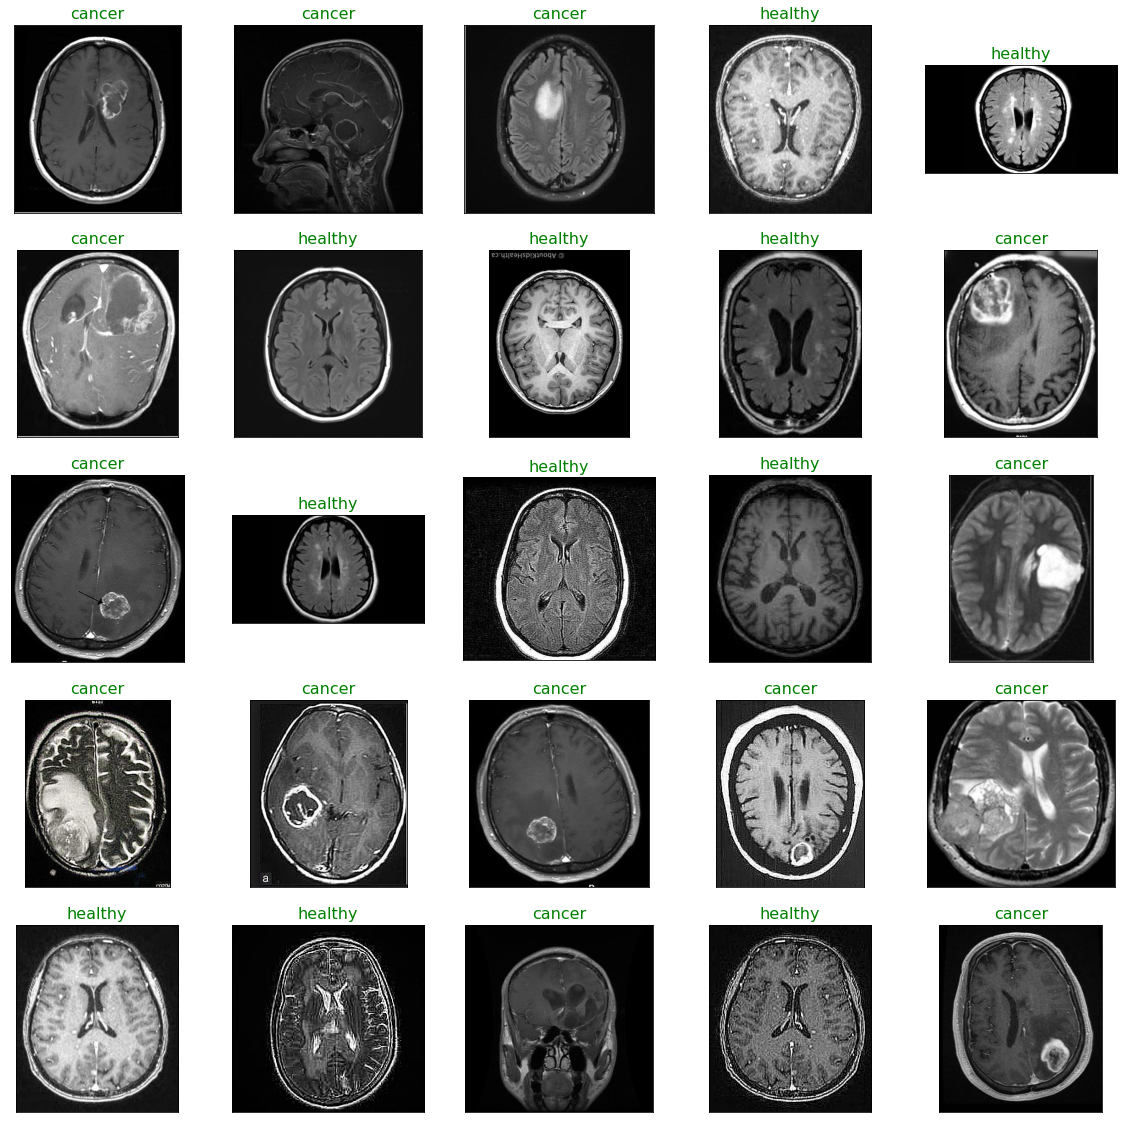

In [10]:
length = len(labels)
if length < 25:
    r = length
else:
    r = 25
plt.figure(figsize=(20,20))
for i in range(r):
    random = np.random.randint(1,len(tumor_df))
    plt.subplot(5,5,i+1)
    plt.imshow(cv2.imread(tumor_df.loc[random,"filepaths"]))
    plt.title(tumor_df.loc[random, "labels"], fontsize = 16, color = "green") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()


## Model Traning

In [18]:
model = Sequential()
# input layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), 
                 activation='relu', input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
#hidden layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation = 'relu'))
#output layer
model.add(Dense(2, activation = 'sigmoid'))

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 242, 242, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 468512)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               59969664  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

In [25]:
History = model.fit(train, validation_data = val, epochs = 10, verbose=1)
History

Epoch 1/10
115/115 [==============================] - 45s 387ms/step - loss: 0.0686 - accuracy: 0.9788 - val_loss: 0.1126 - val_accuracy: 0.9717
Epoch 2/10
115/115 [==============================] - 39s 334ms/step - loss: 0.0662 - accuracy: 0.9812 - val_loss: 0.1208 - val_accuracy: 0.9652
Epoch 3/10
115/115 [==============================] - 40s 348ms/step - loss: 0.0618 - accuracy: 0.9837 - val_loss: 0.1890 - val_accuracy: 0.9554
Epoch 4/10
115/115 [==============================] - 39s 340ms/step - loss: 0.0286 - accuracy: 0.9905 - val_loss: 0.0990 - val_accuracy: 0.9783
Epoch 5/10
115/115 [==============================] - 37s 320ms/step - loss: 0.0279 - accuracy: 0.9924 - val_loss: 0.1278 - val_accuracy: 0.9652
Epoch 6/10
115/115 [==============================] - 38s 329ms/step - loss: 0.0190 - accuracy: 0.9927 - val_loss: 0.1302 - val_accuracy: 0.9707
Epoch 7/10
115/115 [==============================] - 41s 354ms/step - loss: 0.0226 - accuracy: 0.9932 - val_loss: 0.0958 - val_ac

## Visualizing Accuracy and Loss 

Text(0.5, 1.0, 'Traning and Validation Accuracy')

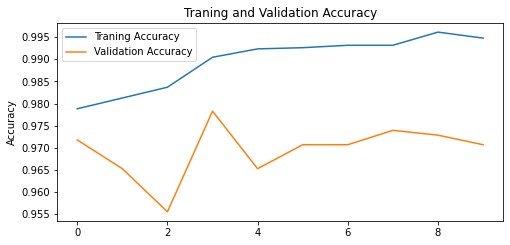

In [26]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

loss = History.history['loss']
val_loss = History.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Traning Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Traning and Validation Accuracy')

Text(0, 0.5, 'loss')

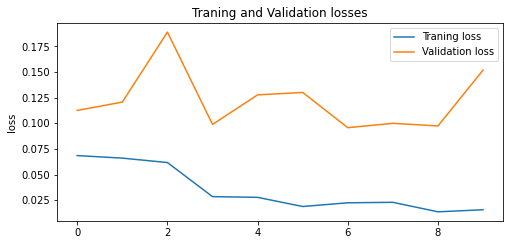

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(loss, label = 'Traning loss')
plt.plot(val_loss ,label = 'Validation loss')

plt.legend()
plt.title('Traning and Validation losses')
plt.ylabel('loss')

In [30]:
model.evaluate(test, verbose = 1)

44/44 [==============================] - 11s 255ms/step - loss: 0.1016 - accuracy: 0.9804


[0.10157995671033859, 0.980434775352478]

In [34]:
pred = model.predict(test)
pred = np.argmax(pred, axis = 1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [40]:
from sklearn.metrics import accuracy_score
y_test = test_images.labels
print(classification_report(y_test, pred2))
print("Accuracy of model: ",accuracy_score(y_test, pred2)*100, '%')

              precision    recall  f1-score   support

      cancer       0.97      0.99      0.98       779
     healthy       0.99      0.96      0.98       601

    accuracy                           0.98      1380
   macro avg       0.98      0.98      0.98      1380
weighted avg       0.98      0.98      0.98      1380

Accuracy of model:  98.04347826086956 %


<AxesSubplot:>

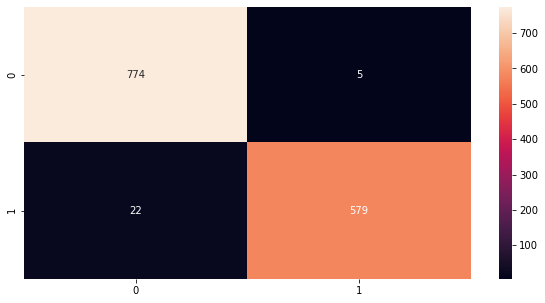

In [44]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm,annot=True, fmt='g')